In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
# Edits
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pylcp
import pylcp.atom as atom
from pylcp.common import cart2spherical
from pylcp.fields import gaussianBeam
#plt.style.use('paper')

In [16]:
# # 50 gauss/cm for Sr 
# # mub on database
# # 0.43 cm for x0 30/1.4/50

# # x is length unit
# # k is wavenumber which relates to wavelength
# x0 = (30/1.4/50) # cm
# k = 2*np.pi/461E-7 # cm^{-1}
# kbar = k*x0

# # D source for position
# d = np.array([0., -8.839/10, -8.839/10])/x0

# Gamma is decay rate
# t0 is normalized time units of decary
# wb is width factor
gamma = 2*np.pi*30e6
t0 = 1e-5 # s
gammabar = gamma*t0
# wb = 4.7 # mm


# zchip = 1.0
# nr=3

# class aPHIMOT(pylcp.laserBeams):
#      def __init__(self, *args, **kwargs):
#         super().__init__()
    
#         beam_type = kwargs.pop('beam_type', pylcp.laserBeam)
#         pol = kwargs.pop('pol', +1)
#         kmag = kwargs.pop('k', 1.)
        
#         self.add_laser(beam_type(kmag*(np.array([0., 0.,  17.678])/(np.linalg.norm(np.array([0., 0.,  17.678])))), +pol, *args, **kwargs))
#         self.add_laser(beam_type(kmag*(np.array([0., 0.,  -17.678])/(np.linalg.norm(np.array([0., 0.,  -17.678])))), +pol, *args, **kwargs))
#         self.add_laser(beam_type(kmag*(np.array([10.825, -13.258, 4.419])/(np.linalg.norm(np.array([10.825, -13.258, 4.419])))), -pol, *args, **kwargs))
#         self.add_laser(beam_type(kmag*(np.array([10.825, 13.258, -4.419])/(np.linalg.norm(np.array([10.825, 13.258, -4.419])))), -pol, *args, **kwargs))
#         self.add_laser(beam_type(kmag*(np.array([-10.825, -13.258, 4.419])/(np.linalg.norm(np.array([-10.825, -13.258, 4.419])))), -pol, *args, **kwargs))
#         self.add_laser(beam_type(kmag*(np.array([-10.825, 13.258, -4.419])/(np.linalg.norm(np.array([-10.825, 13.258, -4.419])))), -pol, *args, **kwargs))
        
# class rotDivGauss(pylcp.laserBeams):
#      def __init__(self, *args, **kwargs):
#         super().__init__()
    
#         beam_type = kwargs.pop('beam_type', pylcp.laserBeam)
#         pol = kwargs.pop('pol', +1)
#         kmag = kwargs.pop('k', 1.)
#         beta = kwargs.pop('beta', 1.0)
#         delta = kwargs.pop('delta', -1.5*gammabar)
        
#         self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([0., 0., -1.]), \
#                        pol=np.array([1., 1.j, 0])/np.sqrt(2), beta=1.0*beta, delta=delta, wb=4.65, r0=np.array([0., 0., 0.]), **kwargs))
# #         self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([0.612, 0.75, -0.25]), \
# #                        pol=np.array([1., -1.j, 0])/np.sqrt(2), beta=1.0*beta, delta=delta, wb=4.65, r0=np.array([0., 0., 0.]), **kwargs))
# #         self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([-0.612, 0.75, -0.25]), \
# #                        pol=np.array([1., -1.j, 0])/np.sqrt(2), beta=1.0*beta, delta=delta, wb=4.65, r0=np.array([0., 0., 0.]), **kwargs))
# #         self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([0., 0., 1.]), \
# #                       pol=np.array([1., 1.j, 0])/np.sqrt(2), beta=6.261e7*beta, delta=delta, wb=5.744e-4, r0=np.array([0., 0., -17.788]), **kwargs))
# #         self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([-0.612, -0.75, 0.25]), \
# #                        pol=np.array([1., -1.j, 0])/np.sqrt(2), beta=6.261e7*beta, delta=delta, wb=5.744e-4, r0=np.array([10.893, 13.341, -4.447]),**kwargs))
# #         self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([0.612, -0.75, 0.25]), \
# #                        pol=np.array([1., -1.j, 0])/np.sqrt(2), beta=6.261e7*beta, delta=delta, wb=5.744e-4, r0=np.array([-10.893, 13.341, -4.447]), **kwargs))
    

# Set up the laser beams with their appropriate characteristics
delta = -1.5*gammabar
beta = 1.0

# #beam_to_sim = pylcp.infinitePlaneWaveBeam
# beam_to_sim = pylcp.gaussianBeam
# #beam_to_sim = pylcp.clippedGaussianBeam

# #MOT_to_sim = conventional3DMOTBeams
# #MOT_to_sim = aPHIMOT
# MOT_to_sim = rotDivGauss

# #MOT_to_sim_kwargs = {'rotation_angles':[np.pi/4, 0., 0.]} # Extra arguments for conventional3DMOTBeams
# MOT_to_sim_kwargs = {} # Extra arguments for aPHIMOT/rotDivGauss

# laser_kwargs = {} # Use for rotDivGauss
# #laser_kwargs = {'wb':wb} # Extra arguments for GaussianBeam
# #laser_kwargs = {'wb':1000*wb, 'rs':wb} # Extra arguments for clippedGaussianBeam

In [17]:
k = np.array([1., 1., 1.])
k = k/np.linalg.norm(k)
laserBeam = gaussianBeam(kvec=np.array([0., 0., 1.]), pol=np.array([1., 1.j, 0])/np.sqrt(2), beta=1.0*beta, delta=delta, wb=2, r0=np.array([0., 0., 0.]))
#laserBeam = MOT_to_sim(beta=beta, delta=det, beam_type=beam_to_sim, k=kbar, **laser_kwargs, **MOT_to_sim_kwargs) # kbar

laserBeam.local_parameters(np.array([100., 10., 1.]), 0.)

(array([0.99380799, 0.0993808 , 0.0496904 ]),
 array([ 0.5248452 +0.j        , -0.70272837-0.07027284j,
         0.46574579+0.09409006j]),
 0.0,
 -2827.433388230814)

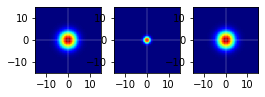

In [18]:
x_beta = 15
X, Y = np.meshgrid(np.linspace(-x_beta, x_beta, 101),
                   np.linspace(-x_beta, x_beta, 101))
z_tests = [-5, 0, +5] # position

plt.figure("Laser Beams", figsize=(4, 1.5*6)) # 6 beams
plt.clf()
# pr = cProfile.Profile()

for ii, z_test in enumerate(z_tests):
    Z = z_test*np.ones(X.shape)
    Rt=np.array([X, Y, Z])

    #pr.enable()
    """it = np.nditer([X, Y, Z, None])
    for (x, y, z, beta) in it:
        beta[...] = laserBeam.beta(np.array([x, y, z]), 0.)
    BETA = it.operands[3]"""
    #pr.disable()
    
    #pr.enable()
    BETA = laserBeam.beta(Rt)
    #pr.disable()

    plt.subplot(1., len(z_tests), ii+1)
    plt.imshow(BETA, origin='lower',
               extent=(-x_beta, x_beta,
                       -x_beta, x_beta))
    #plt.clim((0, 1))
    plt.set_cmap('jet')
    # Make a cross-hair:
    plt.plot([0, 0], [-x_beta, x_beta],
             'w-', linewidth=0.25)
    plt.plot([-x_beta, x_beta], [0, 0],
             'w-', linewidth=0.25)

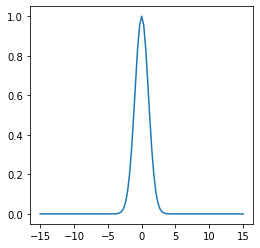

In [19]:
x_beta = 15
X, Y = np.meshgrid(np.linspace(-x_beta, x_beta, 101),
                   np.linspace(-x_beta, x_beta, 101))
z_tests = [0] # position

plt.figure("Laser Beams", figsize=(4, 4)) # 6 beams
plt.clf()
# pr = cProfile.Profile()

for ii, z_test in enumerate(z_tests):
    Z = z_test*np.ones(X.shape)
    Rt=np.array([X, Y, Z])
    
    #pr.enable()
    BETA = laserBeam.beta(Rt)
    #pr.disable()

    plt.subplot(1., len(z_tests), ii+1)
    plt.plot(X[0,:], BETA[50,:])

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


C:\Users\leow0\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w
C:\Users\leow0\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:152: RuntimeWarning: divide by zero encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


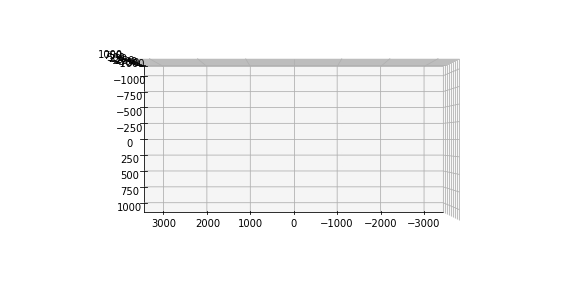

In [20]:
# laserBeam = gaussianBeam(kvec=2*np.pi/461.*np.array([0.,0.,1.])/np.sqrt(3), pol=np.array([1., 1.j, 0.]), beta=beta, delta=delta, \
#                          wb=200., r0=np.array([100.,100.,0.])) # Change the laser beam attributes
print(laserBeam.rmat)

fig = plt.figure(figsize=(10,5)) # Change the size of the plot
ax = fig.gca(projection='3d')

# Make the grid
z, y, x = np.meshgrid(np.arange(-1000., 1001., 200.),
                      np.arange(-1000., 1001., 200.),
                      np.arange(-3000., 3001., 1000.)) # Change the axis

Rt=np.array([x, y, z])

# Make the direction data for the arrows
# u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
# v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
# w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
#      np.sin(np.pi * z))


arr = laserBeam.kvec(Rt)*20000
kx = arr[0]
ky = arr[1]
kz = arr[2]

i = laserBeam.beta(Rt)

ax.quiver(x,y,z,i*kx,i*ky,i*kz)
ax.view_init(90, 90) # change this to see different viewing angles

plt.show()

(353236010.5707458+85792939.16801363j)


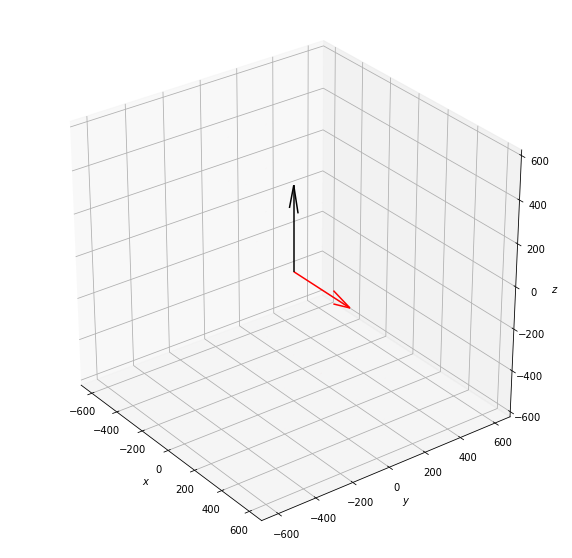

In [21]:
fig = plt.figure(figsize=(10,10)) # Change the size of the plot
ax = fig.gca(projection='3d')

# Make the grid
x, y, z = np.meshgrid(np.arange(-600., 601., 200.),
                      np.arange(-600., 601., 200.),
                      np.arange(-600., 601., 200.)) # Change the axis

Rt=np.array([x, y, z])

arrb, arr1b, ib, deltaLB = laserBeam.local_parameters(Rt)
arr = arrb*20000
arr1 = arr1b*20000
i = ib/50

#arr = laserBeam.kvec(Rt)*20000
kx = arr[0]
ky = arr[1]
kz = arr[2]

#i = laserBeam.beta(Rt)/50

#arr1 = laserBeam.cartesian_pol(Rt)*20000
p0 = arr1[0]
p1 = arr1[1]
p2 = arr1[2]

#print(np.amax(np.sqrt(kx**2+ky**2+kz**2)))
print(np.amax(kx*np.conj(p0)+ky*np.conj(p1)+kz*np.conj(p2))) # Need to divide out because of the 20000 multiplied
#print(np.amax(p1))


#quiver3(r(:,1),r(:,2),r(:,3),Ip.*k(:,1),Ip.*k(:,2),Ip.*k(:,3),'k')
ax.quiver(x,y,z,i*kx,i*ky,i*kz, color='k')

#quiver3(r(:,1),r(:,2),r(:,3),Ip.*real(P(:,1)),Ip.*real(P(:,2)),Ip.*real(P(:,3)),'r')
ax.quiver(x,y,z,i*np.real(p0),i*np.real(p1),i*np.real(p2), color='r')

#quiver3(r(:,1),r(:,2),r(:,3),Ip.*imag(P(:,1)),Ip.*imag(P(:,2)),Ip.*imag(P(:,3)),'b')
ax.quiver(x,y,z,i*np.imag(p0),i*np.imag(p1),i*np.imag(p2), color='b')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')  
ax.set_zlabel('$z$')

ax.view_init(30, -37) # change this to see different viewing angles

plt.show()